# Malaria Cell Images Dataset - Kaggle Dataset for Binary Classification

<img src="https://miro.medium.com/max/1200/1*jcZLpgh3gppeFFgcpFSP0w.jpeg" width="800">

* This workbook illustrates my attempt to solve the [Malaria Images Dataset example](https://www.kaggle.com/iarunava/cell-images-for-detecting-malaria) on Kaggle, which is a **binary classification** problem.
* In this workbook I'll be using Pytorch with a custom Convolutional Neural Network (CNN).
* This workbook also shows you how you can connect to Kaggle from a Colab Notebook and download dataset(s) for use locally - we will be downloading the [Fruits360 dataset](https://www.kaggle.com/moltean/fruits) from Kaggle to our Colab/local environment.

<font color='firebrick'>It is recommended that you run this notebook on a GPU only, like ones available on Google Colab or Kaggle</font>

Following cell sets up access to our Google Drive

In [1]:
# set this flag to True when you run this Notebook on Google Collaboratory
USE_COLAB = False

import os

#@see: https://colab.research.google.com/drive/1srw_HFWQ2SMgmWIawucXfusGzrj1_U0q
if USE_COLAB:
    # Load the Drive helper and mount
    from google.colab import drive

    # We mount our Goofgle Drive to this foloder - following line will prompt for authorization.
    gdrive_mount_point = '/content/drive/'
    drive.mount(gdrive_mount_point)
    # Google drive mapped to: '/content/drive/My Drive'
    grive_path = os.path.join(gdrive_mount_point, "My Drive/")
    print('Your Google Drive is mounted at ', grive_path)
    # COLAB_NOTEBOOKS_PATH: '/content/drive/My Drive/Colab Notebooks'
    COLAB_NOTEBOOKS_PATH = os.path.join(grive_path, "Colab Notebooks/")
    # PYTORCH_COLAB_NOTEBOOKS_PATH: '/content/drive/My Drive/Colab Notebooks/pytorch'
    PYTORCH_COLAB_NOTEBOOKS_PATH = os.path.join(COLAB_NOTEBOOKS_PATH, 'pytorch')
    
    if os.path.exists(PYTORCH_COLAB_NOTEBOOKS_PATH):
        print('You Pytorch Colab notebooks are available at ', PYTORCH_COLAB_NOTEBOOKS_PATH)
    
        # display list of files
        #!ls '/content/drive/My Drive/Colab Notebooks/'

        # append our Google Drive folder to module search 
        # **NOTE:** comment this line out if you are NOT running this notebook on Google Colab
        import sys
        #sys.path.append("/content/drive/My Drive/Colab Notebooks/")
        sys.path.append(PYTORCH_COLAB_NOTEBOOKS_PATH)
        print('NOTE: {} is appended to sys.path!'.format(PYTORCH_COLAB_NOTEBOOKS_PATH))
        # and test it
        import pytorch_toolkit as pytk
        MODEL_SAVE_DIR = os.path.join(PYTORCH_COLAB_NOTEBOOKS_PATH, 'model_states')
        IMAGES_ZIP_DIR = "/content/drive/My Drive/Colab Notebooks/data/kaggle/malaria"
    else:
        raise IOError("Unable to mount Google Drive!")
else:
    MODEL_SAVE_DIR = os.path.join('.','model_states')
    IMAGES_ZIP_DIR = "./images/pytorch/malaria"
    
if not os.path.exists(MODEL_SAVE_DIR):
    os.mkdir(MODEL_SAVE_DIR)
print(f'MODEL_SAVE_DIR = {MODEL_SAVE_DIR}')

MODEL_SAVE_DIR = ./model_states


## Downloading the dataset from Kaggle
You can download datasets directly from Kaggle into a Colab environment by running the following steps:
* Login to your Kaggle account and _create a new API Token_ from your profile page (click the `Create API Token` button and download the `kaggle.json` file locally i.e. to your disk.
* Upload the `kaggle.json` that you downloaded to Colab  and move the file to `~/.kaggle/kaggle.json`
* Install Python packages `kaggle` and `kaggle-cli` that needed to access Kaggle programatically. These can be installed using `pip`
* Now you can access datasets on Kaggle
    * Run `!kaggle datasets list` shell command to list all available datasets (may no be such a useful command!)
    * Run `!datasets list -s <<dataset_name>>` to search for a dataset (e.g. for the Malaria dataset, I used `kaggle list -s malaria`)
    * Copy dataset locally using `!kaggle datasets download -d <<full_path_of_dataset>> -p <<target_folder_path>>`

Run the following cells to download the [Fruits360 dataset](https://www.kaggle.com/moltean/fruits) from Kaggle to your Colab environment.

In [137]:
# assuming you downloaded kaggle.json file to your desktop, run this cell to upload that file to Colab
# this sometimes causes problems, especially if I am behind a firewalls and uploads are jammed!
# This command will display a "upload file" prompt - select the kaggle.json file from your disk & upload

# Uncomment following 2 lines to upload local kaggle.json file to Colab - the file will be uploaded to
# the folder on your Google drive from where you will this this workbook.
# from google.colab import files
# files.upload()

In [2]:
# so I uploaded my kaggle.json to my Google drive, which I can easily copy into Colab workspace :)
if USE_COLAB:
    !ls -al "/content/drive/My Drive/Colab Notebooks/kaggle.json"
else:
    print('NOTE: This cell need not be run locally.')

NOTE: This cell need not be run locally.


In [3]:
# install Python packages require to access Kaggle datasets 
if USE_COLAB:
    !pip install -q kaggle
    !pip install -q kaggle-cli

In [4]:
# Run this cell to copy the uploaded kaggle.json file to ~/.kaggle/kaggle.json 
# Kaggle expects the token file to be located here!!
if USE_COLAB:
    !mkdir -p ~/.kaggle
    !cp "/content/drive/My Drive/Colab Notebooks/kaggle.json" ~/.kaggle/
    # give "me" full access to kaggle.json (i.e. read/write & execute)
    !chmod 600 ~/.kaggle/kaggle.json
    # confirm that ~/.kaggle folder has kaggle.json file
    !ls ~/.kaggle
else:
    kaggle_json_path = os.path.join(
        os.path.expanduser('~'), '.kaggle', 'kaggle.json')
    if not os.path.exists(kaggle_json_path):
        print(f"You need to download your Kaggle credentials and save to {kaggle_json_path}!")
    else:
        print(f'Kaggle credentials found at {kaggle_json_path}')


Kaggle credentials found at /home/mjbhobe/.kaggle/kaggle.json


In [5]:
# Vola! You now have access to Kaggle datasets

# to list **all** the datasets available on Kaggle, run the following shell command
#!kaggle datasets list

In [6]:
# We can look for a specific dataset (e.g. the malaria dataset) like this
# Search Command is: kaggle datasets list -s complete_or_part_name_of_dataset
if USE_COLAB:
    !kaggle datasets list -s malaria  # I don't know the exact name, so I used a part-name - malaria

The first one is the one we are looking for. Let's download the zip file to our `/tmp` folder - **this completes the download of data from Kaggle**

In [7]:
# download command: kaggle datasets download -d <<file_name>> -p <<destination_folder_on_gdrive>>

# our dataset is iarunava/cell-images-for-detecting-malaria 
if USE_COLAB:
    !kaggle datasets download -d iarunava/cell-images-for-detecting-malaria  -p /tmp
    os.listdir('/tmp')
else:
    if not os.path.exists('./data/kaggle/cell-images-for-detecting-malaria.zip'):
        print("Downloading dataset to ./data/kaggle/cell-images-for-detecting-malaria.zip ...", end='', flush=True)
        !kaggle datasets download -d iarunava/cell-images-for-detecting-malaria -p ./data/kaggle
        print("done!")
        print(os.listdir('./data/kaggle'))
    else:
        print(f"cell-images-for-detecting-malaria.zip has already been downloaded!")


100%|███████████████████████████████████████▉| 675M/675M [03:19<00:00, 4.87MB/s]
100%|████████████████████████████████████████| 675M/675M [03:20<00:00, 3.54MB/s]
done!
['cell-images-for-detecting-malaria.zip']


Now that we have _downloaded_ data from Kaggle to our local Colab environment, let's unzip the contents.

In [8]:
# and let us unzip cell-images-for-detecting-malaria.zip to /tmp folder
import os, shutil
import zipfile

zip_file_path = './data/kaggle/cell-images-for-detecting-malaria.zip'
assert os.path.exists(zip_file_path)

out_path = '/tmp' if USE_COLAB else './data/kaggle/malaria-cell-detection'

# check if files already extracted
infected_cell_images_folder = os.path.join(out_path, "cell_images", "Parasitized")
healthy_cell_images_folder = os.path.join(out_path, "cell_images", "Uninfected")

if (not(os.path.exists(infected_cell_images_folder)) or not(os.path.exists(healthy_cell_images_folder))):
    print(f'Extracting all images from {zip_file_path} to {out_path}...', end='', flush=True)
    zip_ref = zipfile.ZipFile(zip_file_path, 'r')

    zip_ref.extractall(out_path)
    zip_ref.close()
    print('done!', flush=True)

assert os.path.exists(infected_cell_images_folder), \
    f'{infected_cell_images_folder} - folder does not exist!'
assert os.path.exists(healthy_cell_images_folder), \
    f'{healthy_cell_images_folder} - folder does not exist!'

print(f"Found {len(os.listdir(infected_cell_images_folder))} parasitized " +
      f"and {len(os.listdir(healthy_cell_images_folder))} images")


Extracting all images from ./data/kaggle/cell-images-for-detecting-malaria.zip to ./data/kaggle/malaria-cell-detection...done!
Found 13780 parasitized and 13780 images


In [145]:
# now unhide the left panel in Colab, click the Files 'tab' & browse to /tmp folder
# you should see the following folders under /tmp
# /tmp
#   + cell_images
#       + Parasitized  (images of infected cells)
#       + Uninfected   (images of healthy cells)

# infected_cell_images_folder = './data/kaggle/malaria-cell-detection/cell_images/Parasitized'
# healthy_cell_images_folder = './data/kaggle/malaria-cell-detection/cell_images/Uninfected'

# assert os.path.exists(infected_cell_images_folder), \
#     f'{infected_cell_images_folder} - folder does not exist!'
# assert os.path.exists(healthy_cell_images_folder), \
#     f'{healthy_cell_images_folder} - folder does not exist!'


## About the Kaggle Dataset

The [Kaggle Malaria Dataset](https://www.kaggle.com/iarunava/cell-images-for-detecting-malaria) contains 2 folders:
* Infected 
* Uninfected

And a total of 27,558 images.

**Acknowledgements**
This Dataset is taken from the official [NIH Website](https://ceb.nlm.nih.gov/repositories/malaria-datasets/)

**Inspiration**
Save humans by detecting and deploying Image Cells that contain Malaria or not!

In [9]:
import warnings
warnings.filterwarnings('ignore')

import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
from PIL import Image
%matplotlib inline

# tweaks for libraries
np.set_printoptions(precision=6, linewidth=1024, suppress=True)
plt.style.use('seaborn')
sns.set(style='darkgrid', context='notebook', font_scale=1.10)

# Pytorch imports
import torch
gpu_available = torch.cuda.is_available()
print('Using Pytorch version %s. GPU %s available' % (torch.__version__, "IS" if gpu_available else "IS **NOT**"))
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch import optim
from torchsummary import summary
# My helper functions for training/evaluating etc.
import pytorch_toolkit as pytk

# to ensure that you get consistent results
# @see: https://discuss.pytorch.org/t/reproducibility-over-different-machines/63047
seed = 123
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
torch.manual_seed(seed);
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.enabled = False

Using Pytorch version 1.10.2. GPU IS **NOT** available


In [10]:
IMAGE_HEIGHT, IMAGE_WIDTH, NUM_CHANNELS, NUM_CLASSES, BATCH_SIZE = 64, 64, 3, 2, 64

In [11]:
infected_images_paths = np.array(glob.glob(os.path.join(infected_cell_images_folder, '*.png')))
infected_images_paths[:10]

images, labels = [],[]

for i, image_path in enumerate(infected_images_paths[:2]):
    img = Image.open(image_path)
    img = img.resize((IMAGE_HEIGHT, IMAGE_WIDTH))
    images.append(img)
    labels.append(1)

print(images)
print(labels)

[<PIL.Image.Image image mode=RGB size=64x64 at 0x7FF9703EC3A0>, <PIL.Image.Image image mode=RGB size=64x64 at 0x7FF9703EC490>]
[1, 1]


In [12]:
def create_imagesets(eval_split=0.30, test_split=0.10):
    import glob

    infected_images_paths = np.array(glob.glob(os.path.join(infected_cell_images_folder, '*.png')))
    healthy_images_paths = np.array(glob.glob(os.path.join(healthy_cell_images_folder, '*.png'))) 
    num_infected_images = len(infected_images_paths)
    num_healthy_images = len(healthy_images_paths)

    print(f'Found {num_healthy_images} healthy images and {num_infected_images} infected images - total {num_healthy_images + num_infected_images}')

    # let us shuffle the file paths, so we can randomly split
    indexes = np.arange(num_infected_images)
    for _ in range(5): indexes = np.random.permutation(indexes)
    infected_images_paths = infected_images_paths[indexes]

    indexes = np.arange(num_healthy_images)
    for _ in range(5): indexes = np.random.permutation(indexes)
    healthy_images_paths = healthy_images_paths[indexes]

    # NOTE: healthy = 0 and infected = 1 (labels)

    num_train_images_healthy = int((1.0 - eval_split) * num_healthy_images)
    train_healthy_images_paths = healthy_images_paths[:num_train_images_healthy]
    train_healthy_images_labels = np.zeros(len(train_healthy_images_paths), dtype=np.int32)
    eval_test_healthy_images_paths = healthy_images_paths[num_train_images_healthy:]
    num_eval_test_healthy_images_paths = len(eval_test_healthy_images_paths)
    num_eval_images_healthy = int((1.0 - test_split) * num_eval_test_healthy_images_paths)
    eval_healthy_images_paths = eval_test_healthy_images_paths[:num_eval_images_healthy]
    eval_healthy_images_labels = np.zeros(len(eval_healthy_images_paths), dtype=np.int32)
    test_healthy_images_paths = eval_test_healthy_images_paths[num_eval_images_healthy:]
    test_healthy_images_labels = np.zeros(len(test_healthy_images_paths), dtype=np.int32)
    assert num_healthy_images == len(train_healthy_images_paths) + len(eval_healthy_images_paths) \
        + len(test_healthy_images_paths)
    print(f'    Randomly splitting {num_healthy_images} healthy images into {len(train_healthy_images_paths)} training' + 
            f' {len(eval_healthy_images_paths)} cross-val and {len(test_healthy_images_paths)} test images')

    num_train_images_infected = int((1.0 - eval_split) * num_infected_images)
    train_infected_images_paths = infected_images_paths[:num_train_images_infected]
    train_infected_images_labels = np.ones(len(train_infected_images_paths), dtype=np.int32)
    eval_test_infected_images_paths = infected_images_paths[num_train_images_infected:]
    num_eval_test_infected_images_paths = len(eval_test_infected_images_paths)
    num_eval_images_infected = int((1.0 - test_split) * num_eval_test_infected_images_paths)
    eval_infected_images_paths = eval_test_infected_images_paths[:num_eval_images_infected]
    eval_infected_images_labels = np.ones(len(eval_infected_images_paths), dtype=np.int32)
    test_infected_images_paths = eval_test_infected_images_paths[num_eval_images_infected:]
    test_infected_images_labels = np.ones(len(test_infected_images_paths), dtype=np.int32)
    assert num_infected_images == len(train_infected_images_paths) + len(eval_infected_images_paths) \
        + len(test_infected_images_paths)
    print(f'    Randomly splitting {num_infected_images} infected images into {len(train_infected_images_paths)} training' + 
            f' {len(eval_infected_images_paths)} cross-val and {len(test_infected_images_paths)} test images')
    
    train_images_paths = np.append(train_healthy_images_paths, train_infected_images_paths)
    train_images_labels = np.append(train_healthy_images_labels, train_infected_images_labels)
    eval_images_paths = np.append(eval_healthy_images_paths, eval_infected_images_paths)
    eval_images_labels = np.append(eval_healthy_images_labels, eval_infected_images_labels)
    test_images_paths = np.append(test_healthy_images_paths, test_infected_images_paths)
    test_images_labels = np.append(test_healthy_images_labels, test_infected_images_labels)

    # shuffle the appended paths
    indexes = np.arange(len(train_images_paths))
    for _ in range(5): indexes = np.random.permutation(indexes)
    train_images_paths = train_images_paths[indexes]
    train_images_labels = train_images_labels[indexes]

    indexes = np.arange(len(eval_images_paths))
    for _ in range(5): indexes = np.random.permutation(indexes)
    eval_images_paths = eval_images_paths[indexes]
    eval_images_labels = eval_images_labels[indexes]

    indexes = np.arange(len(test_images_paths))
    for _ in range(5): indexes = np.random.permutation(indexes)
    test_images_paths = test_images_paths[indexes]
    test_images_labels = test_images_labels[indexes]

    return (train_images_paths, train_images_labels), (eval_images_paths, eval_images_labels), \
        (test_images_paths, test_images_labels)

In [13]:
(train_images_paths, train_images_labels), (eval_images_paths, eval_images_labels), \
        (test_images_paths, test_images_labels) = create_imagesets()
print(f'{train_images_paths.shape}, {train_images_labels.shape}, {eval_images_paths.shape}, {eval_images_labels.shape}, ' +
      f'{test_images_paths.shape}, {test_images_labels.shape}')

Found 13779 healthy images and 13779 infected images - total 27558
    Randomly splitting 13779 healthy images into 9645 training 3720 cross-val and 414 test images
    Randomly splitting 13779 infected images into 9645 training 3720 cross-val and 414 test images
(19290,), (19290,), (7440,), (7440,), (828,), (828,)


In [15]:
from torch.utils.data.dataset import Dataset
from PIL import Image

class MalariaDataset(Dataset):
    def __init__(self, paths, labels, xforms=None):
        assert isinstance(paths, np.ndarray), "paths parameter should be an instance of Numpy array"
        assert isinstance(labels, np.ndarray), "labels parameter should be an instance of Numpy array"

        self.paths = paths
        self.labels = labels
        self.transforms = xforms
        
    def __len__(self):
        return self.paths.shape[0]

    def __getitem__(self, index):
        """
        Open a PIL image, resize to (IMAGE_HEIGHT, IMAGE_WIDTH), apply transforms (if any) & convert to Numpy array
        and return array and label at index
        """
        image_path = self.paths[index]
        assert(os.path.exists(image_path)), f'Invalid path - {image_path} does not exist!'
        img = Image.open(image_path)
        img = img.resize((IMAGE_HEIGHT, IMAGE_WIDTH))
        if self.transforms is not None:
            img = self.transforms(img)
        img = np.array(img).astype(np.float32)
        #img /= 255.0
        label = int(self.labels[index])
        #print(f'returning {img}, {label}')
        return (img, label)

In [16]:
def display_sample(sample_images, sample_labels, sample_predictions=None, grid_shape=(8,8),
                   plot_title=None, fig_size=None):
    """ display a random selection of images & corresponding labels, optionally with predictions
        The display is laid out in a grid of num_rows x num_col cells
        If sample_predictions are provided, then each cell's title displays the prediction 
        (if it matches actual) or actual/prediction if there is a mismatch
    """
    from PIL import Image
    import seaborn as sns

    num_rows, num_cols = grid_shape

    assert len(sample_images) == num_rows * num_cols

    # a dict to help encode/decode the labels
    LABELS = {
        1 : 'Parasitized',
        0 : 'Healthy'
    }
    
    with sns.axes_style("whitegrid"):
        sns.set_context("notebook", font_scale=1.1)
        sns.set_style({"font.sans-serif": ["Verdana", "Arial", "Calibri", "DejaVu Sans"]})

        f, ax = plt.subplots(num_rows, num_cols, figsize=((14, 12) if fig_size is None else fig_size),
            gridspec_kw={"wspace": 0.02, "hspace": 0.25}, squeeze=True)
        #fig = ax[0].get_figure()
        f.tight_layout()
        f.subplots_adjust(top=0.95)
        means, stds = np.array([0.5,0.5,0.5]), np.array([0.5,0.5,0.5])

        for r in range(num_rows):
            for c in range(num_cols):
                image_index = r * num_cols + c
                ax[r, c].axis("off")

                # show selected image
                sample_image = sample_images[image_index]
                # got image as (NUM_CHANNELS, IMAGE_HEIGHT, IMAGE_WIDTH)
                sample_image = sample_image.transpose((1,2,0))
                #sample_image = sample_image * 0.5 + 0.5  # since we applied this normalization
                sample_image = (sample_image * stds) + means
                #sample_image *= 255.0

                ax[r, c].imshow(sample_image)
                
                if sample_predictions is None:
                    # show the actual labels in the cell title
                    title = ax[r, c].set_title("%s" % LABELS[sample_labels[image_index]])
                else:
                    # else check if prediction matches actual value
                    true_label = sample_labels[image_index]
                    pred_label = sample_predictions[image_index]
                    prediction_matches_true = (true_label == pred_label)
                    if prediction_matches_true:
                        # if actual == prediction, cell title is prediction shown in green font
                        title = LABELS[true_label]
                        title_color = 'g'
                    else:
                        # if actual != prediction, cell title is actua/prediction in red font
                        title = '%s\n%s' % (LABELS[true_label], LABELS[pred_label])
                        title_color = 'r'
                    # display cell title
                    title = ax[r, c].set_title(title)
                    plt.setp(title, color=title_color)
        # set plot title, if one specified
        if plot_title is not None:
            f.suptitle(plot_title)

        plt.show()
        plt.close()

In [17]:
# we are scaling all images to same size + converting them to tensors & normalizing data
xforms = {
    'train': transforms.Compose([
        ##torchvision.transforms.RandomAffine(degrees, translate=None, scale=None, shear=None, resample=False, fillcolor=0) 
        transforms.ToTensor(),
        transforms.RandomAffine(0, shear=0.2),         # random shear 0.2
        transforms.RandomAffine(0, scale=(0.8, 1.2)),  # random zoom 0.2
        transforms.RandomRotation(30),
        transforms.RandomHorizontalFlip(),   
        transforms.RandomVerticalFlip(),     
        transforms.CenterCrop((IMAGE_HEIGHT, IMAGE_WIDTH)),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]),
    'eval': transforms.Compose([
        transforms.ToTensor(),
        transforms.CenterCrop((IMAGE_HEIGHT, IMAGE_WIDTH)),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]),
    'test': transforms.Compose([
        transforms.ToTensor(),
        transforms.CenterCrop((IMAGE_HEIGHT, IMAGE_WIDTH)),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]),
}

In [18]:
train_dataset = MalariaDataset(train_images_paths, train_images_labels, xforms=xforms['train'])
eval_dataset = MalariaDataset(eval_images_paths, eval_images_labels, xforms=xforms['eval'])
test_dataset = MalariaDataset(test_images_paths, test_images_labels, xforms=xforms['test'])

print(f"No of training records: {len(train_dataset)}")
print(f"No of cross-val records: {len(eval_dataset)}")
print(f"No of test records: {len(test_dataset)}")

No of training records: 19290
No of cross-val records: 7440
No of test records: 828


In [19]:
loader2 = torch.utils.data.DataLoader(eval_dataset, batch_size=BATCH_SIZE, shuffle=True)
data_iter = iter(loader2)
images2, labels2 = data_iter.next()  # fetch first batch of 64 images & labels
print(f'Eval dataset: image.shape = {images2.shape}, labels.shape = {labels2.shape}')

loader3 = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)
data_iter = iter(loader3)
images2, labels2 = data_iter.next()  # fetch first batch of 64 images & labels
print(f'Test dataset: image.shape = {images2.shape}, labels.shape = {labels2.shape}')

Eval dataset: image.shape = torch.Size([64, 3, 64, 64]), labels.shape = torch.Size([64])
Test dataset: image.shape = torch.Size([64, 3, 64, 64]), labels.shape = torch.Size([64])


Training dataset: image.shape = torch.Size([64, 3, 64, 64]), labels.shape = torch.Size([64])


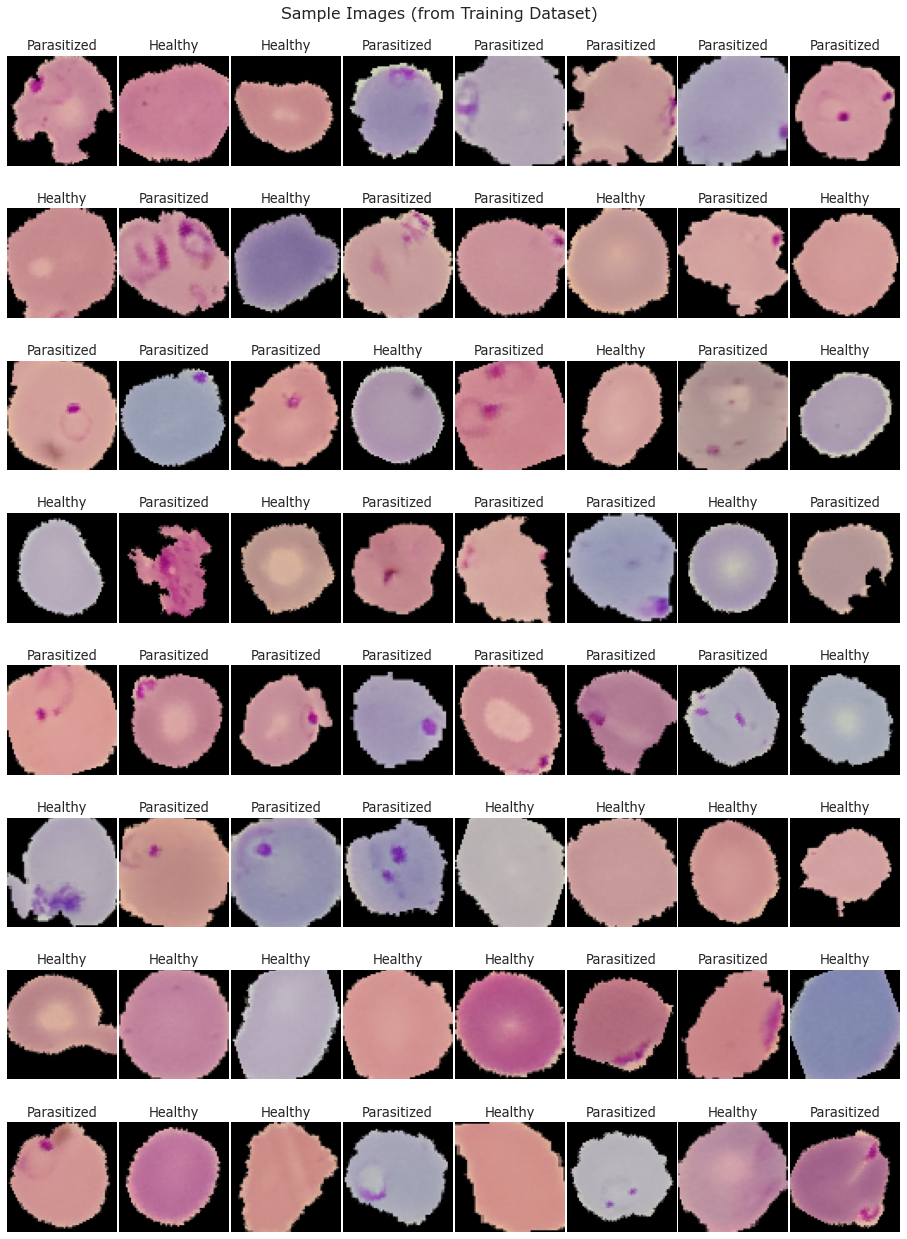

In [20]:
# display sample from train dataset (with our transformations)
loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
data_iter = iter(loader)
images, labels = data_iter.next()  # fetch first batch of 64 images & labels
print(f'Training dataset: image.shape = {images2.shape}, labels.shape = {labels2.shape}')

display_sample(images.cpu().numpy(), labels.cpu().numpy(), grid_shape=(8, 8), 
               fig_size=(16, 20), plot_title='Sample Images (from Training Dataset)')

Test dataset: image.shape = torch.Size([64, 3, 64, 64]), labels.shape = torch.Size([64])


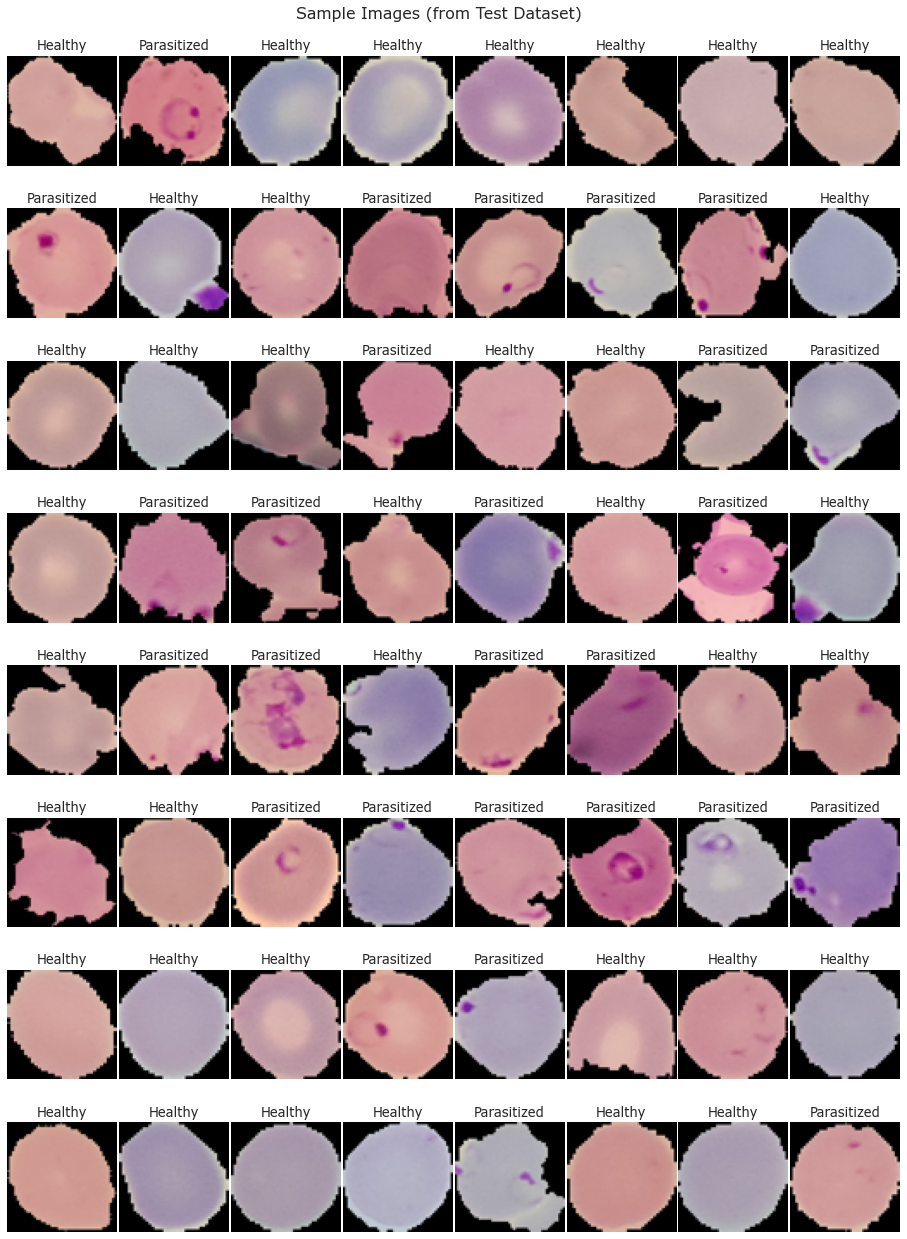

In [21]:
# display sample from test dataset (no transformations)
loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)
data_iter = iter(loader)
images, labels = data_iter.next()  # fetch first batch of 64 images & labels
print(f'Test dataset: image.shape = {images2.shape}, labels.shape = {labels2.shape}')

display_sample(images.cpu().numpy(), labels.cpu().numpy(), grid_shape=(8, 8), 
               fig_size=(16, 20), plot_title='Sample Images (from Test Dataset)')

## Building our custom CNN Model

In [22]:
# training specific hyper parameters
LR_RATE, L2_REG, STEP_SIZE, GAMMA = 0.001, 0.0005, 10, 1.0/10.0
NUM_EPOCHS = 50
MODEL_SAVE_PATH = os.path.join(MODEL_SAVE_DIR, 'pyt_malaria_cnn.pyt')
print(f"Model state will be saved to {MODEL_SAVE_PATH}")

Model state will be saved to ./model_states/pyt_malaria_cnn.pyt


In [23]:
try:
    del cnn_model
except NameError:
    pass

try:
    del model
except NameError:
    pass

In [24]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)


def build_model():
    cnn = nn.Sequential(
        pytk.Conv2d(NUM_CHANNELS, 64, 5, padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(64),
        nn.MaxPool2d(kernel_size=2, stride=2),

        pytk.Conv2d(64, 128, 5, padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(128),
        nn.MaxPool2d(kernel_size=2, stride=2),

        pytk.Conv2d(128, 256, 3, padding=0),
        nn.ReLU(),
        nn.BatchNorm2d(256),
        nn.MaxPool2d(kernel_size=2, stride=2),

        pytk.Conv2d(256, 512, 3, padding=0),
        nn.ReLU(),
        nn.BatchNorm2d(512),
        nn.MaxPool2d(kernel_size=2, stride=2),

        nn.Flatten(),
        nn.Dropout(0.3),
        
        nn.Linear(512 * 2 * 2, 1024),
        nn.ReLU(),
        nn.Dropout(0.2),

        nn.Linear(1024, 512),
        nn.ReLU(),
        nn.Dropout(0.2),
        
        nn.Linear(512, 256),
        nn.ReLU(),
        nn.Dropout(0.1),

        nn.Linear(256, NUM_CLASSES)
    )


    model = pytk.PytkModuleWrapper(cnn)
    criterion = nn.CrossEntropyLoss()
    #optimizer = optim.SGD(params=model.parameters(), lr=LR_RATE, momentum=0.8, nesterov=False, weight_decay=L2_REG)
    optimizer = optim.Adam(params=model.parameters(), lr=LR_RATE, weight_decay=L2_REG)
    model.compile(loss=criterion, optimizer=optimizer, metrics=['acc'])
    return model, optimizer

In [25]:
model, optimizer = build_model()
print(model.summary((NUM_CHANNELS, IMAGE_HEIGHT, IMAGE_WIDTH)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 62, 62]           4,864
              ReLU-2           [-1, 64, 62, 62]               0
       BatchNorm2d-3           [-1, 64, 62, 62]             128
         MaxPool2d-4           [-1, 64, 31, 31]               0
            Conv2d-5          [-1, 128, 29, 29]         204,928
              ReLU-6          [-1, 128, 29, 29]               0
       BatchNorm2d-7          [-1, 128, 29, 29]             256
         MaxPool2d-8          [-1, 128, 14, 14]               0
            Conv2d-9          [-1, 256, 12, 12]         295,168
             ReLU-10          [-1, 256, 12, 12]               0
      BatchNorm2d-11          [-1, 256, 12, 12]             512
        MaxPool2d-12            [-1, 256, 6, 6]               0
           Conv2d-13            [-1, 512, 4, 4]       1,180,160
             ReLU-14            [-1, 51

In [26]:
from torch.optim.lr_scheduler import StepLR
scheduler = StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)

In [27]:
hist = model.fit_dataset(train_dataset, validation_dataset=eval_dataset, epochs=NUM_EPOCHS, 
                         batch_size=BATCH_SIZE, lr_scheduler=scheduler) # num_workers=3, verbose=1)

Training on CPU...
Training on 19290 samples, cross-validating on 7440 samples
Epoch ( 1/50): (19290/19290) -> loss: 0.2577 - acc: 0.9012 - val_loss: 0.1460 - val_acc: 0.9562 - lr: ['0.00100000']
Epoch ( 2/50): (19290/19290) -> loss: 0.1736 - acc: 0.9469 - val_loss: 0.1507 - val_acc: 0.9549 - lr: ['0.00100000']
Epoch ( 3/50): (19290/19290) -> loss: 0.1635 - acc: 0.9495 - val_loss: 0.1476 - val_acc: 0.9485 - lr: ['0.00100000']
Epoch ( 4/50): (19290/19290) -> loss: 0.1630 - acc: 0.9495 - val_loss: 0.1385 - val_acc: 0.9563 - lr: ['0.00100000']
Epoch ( 5/50): (19290/19290) -> loss: 0.1592 - acc: 0.9517 - val_loss: 0.1447 - val_acc: 0.9549 - lr: ['0.00100000']
Epoch ( 6/50): (19290/19290) -> loss: 0.1603 - acc: 0.9508 - val_loss: 0.1436 - val_acc: 0.9579 - lr: ['0.00100000']
Epoch ( 7/50): (19290/19290) -> loss: 0.1543 - acc: 0.9522 - val_loss: 0.1388 - val_acc: 0.9591 - lr: ['0.00100000']
Epoch ( 8/50): (19290/19290) -> loss: 0.1478 - acc: 0.9519 - val_loss: 0.1326 - val_acc: 0.9589 - lr: 

In [ ]:
pytk.show_plots(hist, metric='acc', plot_title='Pytorch Custom CNN Performance')

In [ ]:
# evaluate performance on train, cross-val & test data
loss, acc = model.evaluate_dataset(train_dataset)
print('Training data  -> loss: %.3f, acc: %.3f' % (loss, acc))
loss, acc = model.evaluate_dataset(eval_dataset)
print('Cross-val data -> loss: %.3f, acc: %.3f' % (loss, acc))
loss, acc = model.evaluate_dataset(test_dataset)
print('Testing data   -> loss: %.3f, acc: %.3f' % (loss, acc))

**Observations:**

>Configuration | Training Acc | Cross-Val Acc | Testing Acc | Comments 
>---:|:---:|:---:|:---:|---:|
>**Custom Model**| 95.1%|95.5%|96.0%| Base model
>**Custom Model with StepLR**| 96.5%|96.7%|96.1% | Slightly Better performance

* From the loss & accuracy plots, we see that the model is slightly under-fitting our data - there is a ~1% difference between train & test accuracies (train & cross-validation accuracies are in step)
* Cross-validation & test accuracies are almost the same - this should be expected as samples were drawn from the same _population_ (viz. the test dataset). **With more epochs, we get but a slight improvement in performance**

In [ ]:
model.save(MODEL_SAVE_PATH)
del model

## Running Predictions

In [ ]:
model, optimizer = build_model()
model.load(MODEL_SAVE_PATH) 
print(model.summary((NUM_CHANNELS, IMAGE_HEIGHT, IMAGE_WIDTH)))

In [ ]:
# evaluate performance on train, cross-val & test data
loss, acc = model.evaluate_dataset(train_dataset)
print('Training data  -> loss: %.3f, acc: %.3f' % (loss, acc))
loss, acc = model.evaluate_dataset(eval_dataset)
print('Cross-val data -> loss: %.3f, acc: %.3f' % (loss, acc))
loss, acc = model.evaluate_dataset(test_dataset)
print('Testing data   -> loss: %.3f, acc: %.3f' % (loss, acc))

In [ ]:
# display sample from test dataset
print('Running predictions....')

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

actuals, predictions = [], []

for batch_no, (images, labels) in enumerate(test_loader):
    # images, labels = data_iter.next()  # fetch first batch of 64 images & labels
    preds = model.predict(images)
    actuals.extend(labels.cpu().numpy().ravel())
    predictions.extend(np.argmax(preds, axis=1).ravel())

actuals = np.array(actuals)
predictions = np.array(predictions)

print('Sample actual values & predictions...')
print('  - Acutal values: ', actuals[:25])
print('  - Predictions  : ', predictions[:25])
correct_preds = (actuals == predictions).sum()
acc = correct_preds / len(actuals)
print('  We got %d of %d correct (%.3f accuracy)' % (correct_preds, len(actuals), acc))

from sklearn.metrics import confusion_matrix, classification_report
print(classification_report(actuals, predictions))
# pyt.plot_confusion_matrix(confusion_matrix(actuals, predictions), ['Healthy', 'Infected'])

In [ ]:
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)
data_iter = iter(test_loader)

In [ ]:
images, labels = data_iter.next()

preds = model.predict(images)
preds = np.argmax(preds, axis=1)

print(images.shape, labels.shape, preds.shape)

display_sample(images.cpu().numpy(), labels.cpu().numpy(), sample_predictions=preds, 
               grid_shape=(8, 8), fig_size=(16, 20), plot_title='Sample Predictions')

## Using a pre-trained CNN Model
In this section we'll use the pre-trained ResNet model

In [25]:
from torchvision import models
MODEL_SAVE_PATH_PT = os.path.join(MODEL_SAVE_DIR, 'pyt_malaria_vgg16.pyt')
print(MODEL_SAVE_PATH_PT)

.\model_states\pyt_malaria_vgg16.pyt


In [26]:
# here is the base model
vgg_model = models.vgg16(pretrained=True)
print(vgg_model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [27]:
def build_pretrained_model():
    vgg_model = models.vgg16(pretrained=True)

    # freeze the weights if the feature detector
    for param in vgg_model.features.parameters():
        param.requires_grad = False

    # add on our custom classifier
    custom_classifier = nn.Sequential(
        #nn.Dropout(0.30),
        nn.Linear(512 * 7 * 7, 2048),
        nn.ReLU(),
        nn.Dropout(0.10),
        nn.Linear(2048, 1024),
        nn.ReLU(),
        nn.Dropout(0.10),
        nn.Linear(1024, 512),
        nn.ReLU(),
        nn.Dropout(0.10),
        nn.Linear(512, NUM_CLASSES)
    )
    # custom_classifier = nn.Sequential(
    #     nn.Dropout(0.3),

    #     nn.Linear(512 * 7 * 7, 1024),
    #     nn.ReLU(),
    #     nn.Dropout(0.2),

    #     nn.Linear(1024, 512),
    #     nn.ReLU(),
    #     nn.Dropout(0.2),

    #     nn.Linear(512, NUM_CLASSES)
    # )
    # replace vgg16_base's classifier with ours
    vgg_model.classifier = custom_classifier
    print("Customized VGG16 classifier")
    print(vgg_model)

    # wrap it in our Pytk class
    model = pytk.PytkModuleWrapper(vgg_model)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(params=model.parameters(), lr=LR_RATE, momentum=0.8,
                          nesterov=False, weight_decay=L2_REG)
    model.compile(loss=criterion, optimizer=optimizer, metrics=['acc'])
    return model, optimizer


In [31]:
model, optimizer = build_pretrained_model()
print(model.summary((NUM_CHANNELS, IMAGE_HEIGHT, IMAGE_WIDTH)))

Customized VGG16 classifier
VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, str

In [32]:
hist = model.fit_dataset(train_dataset, validation_dataset=eval_dataset, epochs=15,
                         batch_size=128)

Training on CPU...
Training on 19290 samples, cross-validating on 7440 samples
Epoch ( 1/15): (19290/19290) -> loss: 0.6933 - acc: 0.4964 - val_loss: 0.6932 - val_acc: 0.5000 - lr: ['0.00100000']
Epoch ( 2/15): (19290/19290) -> loss: 0.6932 - acc: 0.4972 - val_loss: 0.6931 - val_acc: 0.5000 - lr: ['0.00100000']
Epoch ( 3/15): (19290/19290) -> loss: 0.6932 - acc: 0.5014 - val_loss: 0.6931 - val_acc: 0.5000 - lr: ['0.00100000']
Epoch ( 4/15): (19290/19290) -> loss: 0.6932 - acc: 0.4934 - val_loss: 0.6931 - val_acc: 0.5000 - lr: ['0.00100000']
Epoch ( 5/15): (19290/19290) -> loss: 0.6932 - acc: 0.4934 - val_loss: 0.6931 - val_acc: 0.5000 - lr: ['0.00100000']
Epoch ( 6/15): (19290/19290) -> loss: 0.6932 - acc: 0.5009 - val_loss: 0.6932 - val_acc: 0.5000 - lr: ['0.00100000']
Epoch ( 7/15): (19290/19290) -> loss: 0.6933 - acc: 0.4967 - val_loss: 0.6931 - val_acc: 0.5000 - lr: ['0.00100000']
Epoch ( 8/15): (19290/19290) -> loss: 0.6932 - acc: 0.5009 - val_loss: 0.6932 - val_acc: 0.5000 - lr: 

KeyboardInterrupt: 

In [ ]:
pytk.show_plots(hist, metric='acc',plot_title='Pytorch Pretrained VGG16 model')

In [ ]:
MODEL_SAVE_PATH_PT = os.path.join(MODEL_SAVE_DIR, 'pyt_malaria_vgg16.pyt')
print(f"Model state will be saved to {MODEL_SAVE_PATH_PT}")

In [ ]:
# evaluate performance on train, cross-val & test data
loss, acc = model.evaluate_dataset(train_dataset)
print('Training data  -> loss: %.3f, acc: %.3f' % (loss, acc))
loss, acc = model.evaluate_dataset(eval_dataset)
print('Cross-val data -> loss: %.3f, acc: %.3f' % (loss, acc))
loss, acc = model.evaluate_dataset(test_dataset)
print('Testing data   -> loss: %.3f, acc: %.3f' % (loss, acc))

In [ ]:
model.save(MODEL_SAVE_PATH_PT)
del model

## Conclusion
* In this notebook, we wrote a custom dataset to load images from disk
* We also wrote a custom CNN based classifier to classify the cell images as infected or healthy.
* We were able to achieve relatively good performance on test dataset (~97% accuracy).

# <center>---- END ----</center>